In [2]:
!pip install -q swig
!pip install -q gymnasium[box2d]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


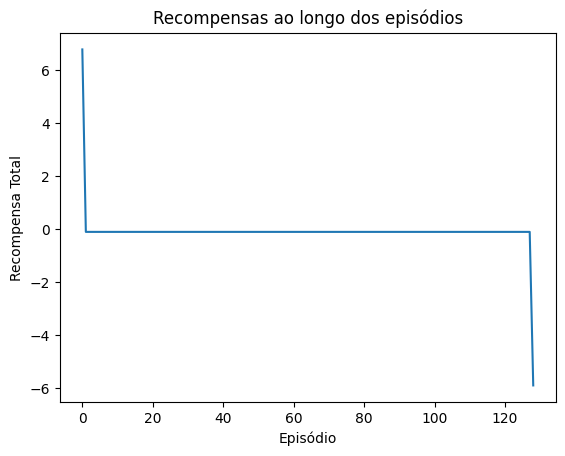

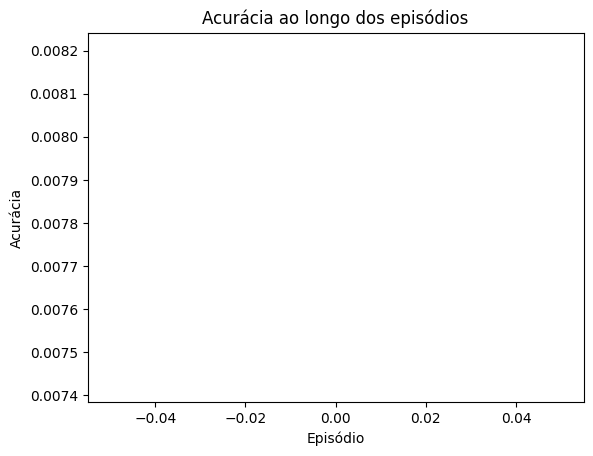

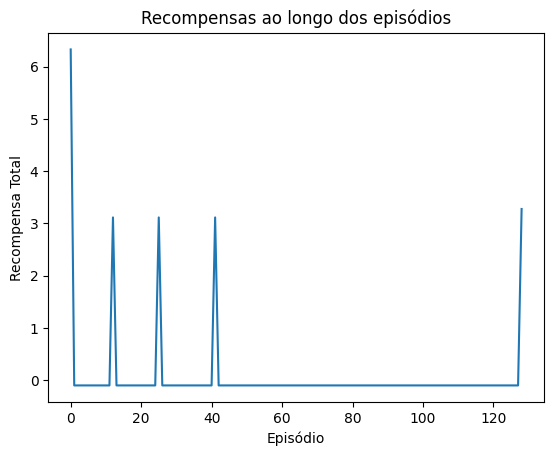

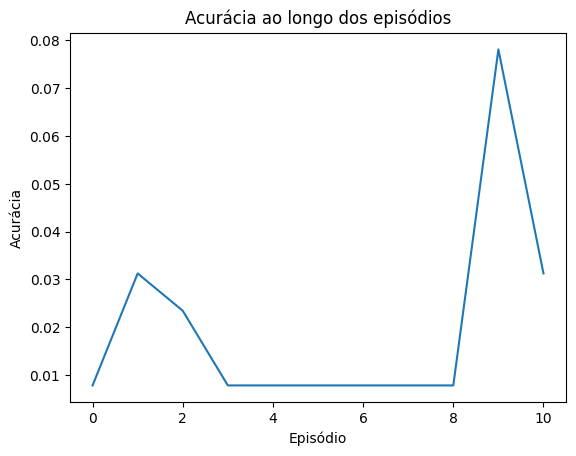

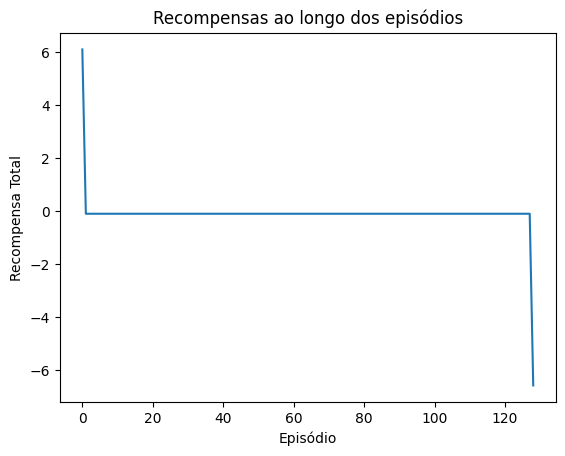

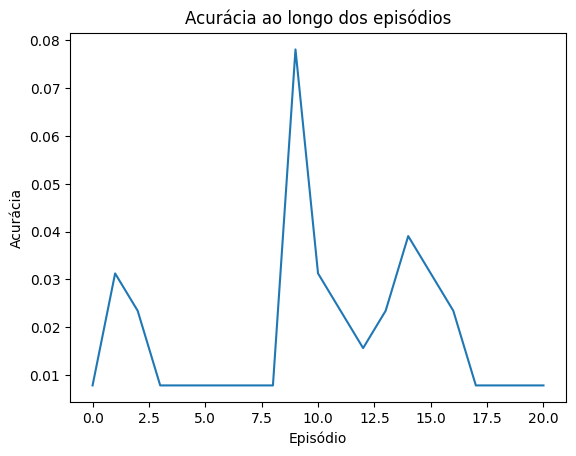

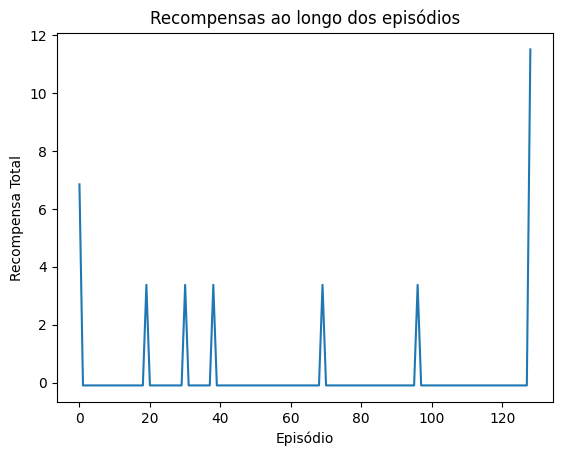

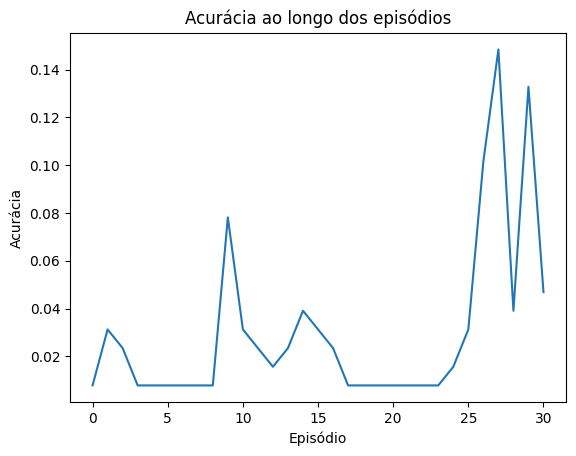

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torchvision.transforms as T

taxa_aprendizado = 0.00005
gamma = 0.75
eps_clip = 0.15
K_epocas = 20
T_horizonte = 128

class PPO(nn.Module):
    def __init__(self, dimensao_entrada, dimensao_saida):
        super(PPO, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(dimensao_entrada[0], 16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
        )

        dim_saida_conv = self._obter_saida_conv(dimensao_entrada)
        self.fc = nn.Sequential(
            nn.Linear(dim_saida_conv, 256),
            nn.ReLU(),
            nn.Linear(256, dimensao_saida)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _obter_saida_conv(self, forma):
        o = self.conv(torch.zeros(1, *forma))
        return int(np.prod(o.size()))

def surrogate_clipping(policy, policy_antigo, estados, acoes, recompensas, vantagens):
    logits = policy(estados)
    logits_antigos = policy_antigo(estados)

    dist = Normal(logits, 1)
    dist_antigos = Normal(logits_antigos, 1)

    log_probabilidade = dist.log_prob(acoes).sum(dim=-1)
    log_probabilidade_antigos = dist_antigos.log_prob(acoes).sum(dim=-1)

    razao = torch.exp(log_probabilidade - log_probabilidade_antigos)
    surrogate = razao * vantagens
    surrogate_clipped = torch.clamp(razao, 1-eps_clip, 1+eps_clip) * vantagens

    return -torch.min(surrogate, surrogate_clipped).mean()

def main():
    env = gym.make('CarRacing-v2')
    dimensao_estado = env.observation_space.shape
    dimensao_acao = env.action_space.shape[0]

    politica = PPO((dimensao_estado[2], 96, 96), dimensao_acao)
    politica_antiga = PPO((dimensao_estado[2], 96, 96), dimensao_acao)
    politica_antiga.load_state_dict(politica.state_dict())

    otimizador = optim.Adam(politica.parameters(), lr=taxa_aprendizado)

    recompensas = []
    accuracies = []

    for episodio in range(300):
        estado = env.reset()
        recompensa_total = 0
        acertos = 0
        total = 0
        log_probs = []
        valores = []
        recompensas = []
        mascaras = []

        for t in range(T_horizonte):
            estado = torch.tensor(estado, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
            acao_media = politica(estado)
            dist = Normal(acao_media, 1)
            acao = dist.sample().squeeze(0)

            proximo_estado, recompensa, done, _ = env.step(acao.numpy())
            recompensa_total += recompensa

            log_prob = dist.log_prob(acao).unsqueeze(0)
            valor = politica(estado)

            log_probs.append(log_prob)
            valores.append(valor)
            recompensas.append(torch.tensor(recompensa, dtype=torch.float32))
            mascaras.append(torch.tensor(1 - done, dtype=torch.float32))

            estado = proximo_estado

            # Calculando a acurácia
            total += 1
            if recompensa > 0:  # Defina sua condição para sucesso aqui
                acertos += 1

            if done:
                break

        accuracy = acertos / total if total != 0 else 0
        accuracies.append(accuracy)

        proximo_estado = torch.tensor(proximo_estado, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        valor_proximo_estado = politica(proximo_estado)
        retornos = calcular_retornos(valor_proximo_estado, recompensas, mascaras)

        log_probs = torch.cat(log_probs)
        retornos = torch.cat(retornos).detach()
        valores = torch.cat(valores)

        vantagem = retornos - valores
        vantagem = (vantagem - vantagem.mean()) / (vantagem.std() + 1e-10)

        perda_ator = -(log_probs * vantagem.detach()).mean()
        perda_critic = (retornos - valores).pow(2).mean()
        perda = perda_ator + perda_critic

        otimizador.zero_grad()
        perda.backward()
        otimizador.step()

        recompensas.append(recompensa_total)

        if episodio % 10 == 0:
            plt.plot(recompensas)
            plt.title('Recompensas ao longo dos episódios')
            plt.xlabel('Episódio')
            plt.ylabel('Recompensa Total')
            plt.show()

            plt.plot(accuracies)
            plt.title('Acurácia ao longo dos episódios')
            plt.xlabel('Episódio')
            plt.ylabel('Acurácia')
            plt.show()

def calcular_retornos(proximo_valor, recompensas, mascaras):
    R = proximo_valor
    retornos = []
    for passo in reversed(range(len(recompensas))):
        R = recompensas[passo] + gamma * R * mascaras[passo]
        retornos.insert(0, R)
    return retornos

if __name__ == '__main__':
    main()
